# Mustafa's Data Processing
### This script reads the dust AOD data, land cover data, and elevation data and align teh CRS and the resolution to match across datasets

In [3]:
# pre amble. reading the needed libraries
import os
import glob
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

### 1. Read the datasets

In [4]:
### let us start with AOD
# Define directories and file structure
data_dir = "/Users/mustafazahid/Library/CloudStorage/GoogleDrive-mhzahid@berkeley.edu/My Drive/dust_pm/daod_midas/data/processed"
start_year = 2003
end_year = 2017

# Store results
daily_datasets = {}

# Loop through years and read data
for year in range(start_year, end_year + 1):
    year_dir = os.path.join(data_dir, str(year))
    tiff_files = glob.glob(os.path.join(year_dir, "*.tif"))
    
    # Read each GeoTIFF file in the year directory
    for tiff_file in tiff_files:
        date_str = os.path.basename(tiff_file).split('-')[-1].replace(".tif", "")
        with rasterio.open(tiff_file) as src:
            data = src.read(1)  # Read the first (and often only) band
            daily_datasets[date_str] = {
                "data": data,
                "transform": src.transform,
                "crs": src.crs,
            }

print(f"Loaded {len(daily_datasets)} datasets.")

Loaded 5336 datasets.


In [7]:
### now let us move on into elevation 

# Path to elevation raster
elevation_file = "/Users/mustafazahid/Library/CloudStorage/GoogleDrive-mhzahid@berkeley.edu/My Drive/dust_pm/elevation/raw/stanford-rm470dn6126-geotiff.tif"

# Example CRS and transform from one of the dust AOD rasters
# Replace with actual values from your AOD dataset
target_crs = "EPSG:4326"  # Example CRS, update if needed
target_transform = rasterio.Affine(0.1, 0, -180, 0, -0.1, 90)  # Example transform
target_width = 3600  # Example width (number of columns), update if needed
target_height = 1800  # Example height (number of rows), update if needed

# Read the elevation raster
with rasterio.open(elevation_file) as src:
    elev_data = src.read(1)  # Read the first band
    elev_crs = src.crs
    elev_transform = src.transform
    elev_meta = src.meta

# Create an empty array for the reprojected data
aligned_elev_data = np.empty((target_height, target_width), dtype=elev_data.dtype)

# Reproject and align the elevation raster
reproject(
    source=elev_data,
    destination=aligned_elev_data,
    src_transform=elev_transform,
    src_crs=elev_crs,
    dst_transform=target_transform,
    dst_crs=target_crs,
    resampling=Resampling.bilinear,  # Bilinear interpolation for smoother results
)

print("Elevation raster aligned with AOD rasters.")


Elevation raster aligned with AOD rasters.


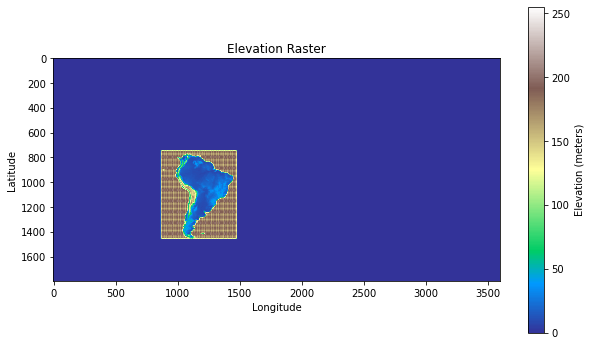

In [30]:
import matplotlib.pyplot as plt

# Assuming 'aligned_elev_data' contains the reprojected elevation raster
# For simplicity, ensure NaN values (if any) are handled
masked_elev_data = np.ma.masked_invalid(aligned_elev_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.imshow(masked_elev_data, cmap='terrain') # Adjust extent to match your raster
plt.colorbar(label="Elevation (meters)")
plt.title("Elevation Raster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

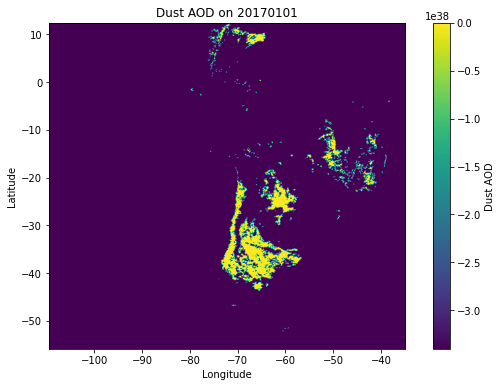

In [34]:
# Example: Plotting a specific daily dust AOD raster
# Assuming 'daily_datasets' is a dictionary where each key is the date string, and the value contains the data

# Choose a date to plot (replace with an actual date string from your dataset)
date_to_plot = "20170101"  # Replace with a valid date key in your dataset
aod_data = daily_datasets[date_to_plot]["data"]
aod_transform = daily_datasets[date_to_plot]["transform"]

# Get geographic bounds from the transform
from rasterio.plot import show
bounds = rasterio.transform.array_bounds(aod_data.shape[0], aod_data.shape[1], aod_transform)

# Create the plot
plt.figure(figsize=(10, 6))
plt.imshow(
    aod_data, 
    cmap="viridis",  # Choose a colormap suitable for the data
    extent=(bounds[0], bounds[2], bounds[1], bounds[3])  # Extent from transform
)
plt.colorbar(label="Dust AOD")
plt.title(f"Dust AOD on {date_to_plot}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
### finally NDVI